# Common Section
Functions and Function usage examples are in the two cells that follow

In [96]:
# For your development, copy all code from this cell and put it in your ipynb
# As far as I've read, there's no simple way of directly sharing code
#   across .ipynb notebooks; which really sucks.

using Images, DataFrames, FixedPointNumbers, PyPlot, Colors, ProgressMeter

# loads all jpg image files inside the directory
function get_image_files(image_dir)
    # get all the files in the directory
    dir_contents = readdir(image_dir)
    dir_contents = [ join([image_dir, dir_contents[i]], "/") for i in 1:length(dir_contents) ]
    
    # retain only jpg image files
    image_files = filter(x->ismatch(r"(.jpg$)|(.jpeg$)"i, x), dir_contents)
    
    # return the paths to the jpg image files
    return image_files
end

# converts image to a h x w matrix
#   h = height
#   w = width
function convert_image_to_mat(image)
    image_mat = reinterpret(UInt8, separate(image).data)
    return image_mat
end

# converts a h x w matrix to an Images module image
function convert_mat_to_image(image_mat)
    image = colorim(image_mat)
    return image
end

# load a list of image files as a cell array of image matrices
function load_images_as_cellarray_mats(image_files)
    images_mat = cell(length(image_files),1)
    for (image_n, image_file) in enumerate(image_files)
        image = load(image_file)
        image_mat = convert_image_to_mat(image)
        images_mat[image_n] = image_mat
    end
    return images_mat
end

# convert a cell array of image matrices to a cell array of images
function load_cellarray_mats_as_images(images_mat)
    images = cell(length(images_mat),1)
    for (image_n, image_mat) in enumerate(images_mat)
        image = convert_mat_to_image(image_mat)
        images[image_n] = image
    end
    return images
end

# silly way to make all images the same size
function subsample_cellarray_mats(images_mat, desired_size)
    for (image_n, image) in enumerate(images_mat)
        images_mat[image_n] = image[1:desired_size[2], 1:desired_size[1], :]
    end
    return images_mat
end

; # suppress display

INFO: Precompiling module ProgressMeter...


In [4]:
# function usage examples summary
#   if you write any new functions in your code, please maintain two such cells
#   e.g. like cell above, one cell with ALL the functions
#        like this cell, a summary of all the function that you have written, with an example syntax

# image_files = get_image_files("./beer1800")
# images_mat = load_images_as_cellarray_mats(image_files)
# images = load_cellarray_mats_as_images(images_mat)
# image_mat = convert_image_to_mat(images[1])
# image = convert_mat_to_image(image_mat)

# Individual Section
At the moment the cells that follow just have dummy code. I will be using the cells below for my own experiments.

My suggestion - Let's copy the code in the first two cells (common section) and do our own experiments in separate files. We can meet regularly and decide what functions that we write will be ported to the final submission and merge it accordingly.

Another suggestion - I've named this file as **main\_ananth.ipynb**. If you guys also follow the same convention (**main\_\<name\>.ipynb**) for consistency, it would be great. Also, this way, we can name our final code as **main.ipynb** and rename it later as we see fit.

In [89]:
# load data
image_files = get_image_files("./beer1800")
images_mat = load_images_as_cellarray_mats(image_files)
desired_size = (10,10)
images_mat = subsample_cellarray_mats(images_mat, desired_size)

test_image_files = get_image_files("./test_images")
test_images_mat = load_images_as_cellarray_mats(test_image_files)
test_image = test_images_mat[1]

; # to suppress display

In [ ]:
# series of optimization models for fixed number of images
using JuMP, Mosek

n_basis = length(images_mat)
w_basis = size(images_mat[1], 2)
h_basis = size(images_mat[1], 1)
w_test_image = size(test_image, 2)
h_test_image = size(test_image, 1)

n_basis_width = round(Int64, w_test_image/w_basis)
n_basis_height = round(Int64, h_test_image/h_basis)

# output
basis_choice = zeros(n_basis_height, n_basis_width)
mosaic_image = zeros(size(test_image))

n_colors = 3
basis_colors = zeros(n_basis, n_colors)
for color in 1:n_colors
    for basis in 1:n_basis
        basis_colors[basis,color] = mode(images_mat[basis][:,:,color])
    end
end

@showprogress 1 for j = 1:n_basis_height
    for i = 1:n_basis_width
        # pick the closes resembling basis image
        m = Model(solver = MosekSolver(LOG=1))
        @defVar(m, pick_basis[1:n_basis], Bin)
        @defVar(m, AbsMatchError[1:n_colors] >= 0)
        
        @addConstraint(m, sum(pick_basis) == 1)
        
        sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
        
        @defExpr(m, MatchError[color in 1:n_colors], mode(sub_test_image[:,:,color]) - 
                                                     sum(dot(pick_basis,basis_colors[:,color])) )
        @addConstraint(m, MatchError .<=  AbsMatchError)
        @addConstraint(m, MatchError .>= -AbsMatchError)
        
        @setObjective(m, Min, sum(AbsMatchError))
        
        status = solve(m)
        
        # show some output to communicate that things are moving forward
        # print("(", j, ",", i, ") ... ")
        
        opt_pick_basis = getValue(pick_basis)
        chosen_basis = findfirst(opt_pick_basis)
        basis_choice[j,i] = chosen_basis
        
        mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
    end
end

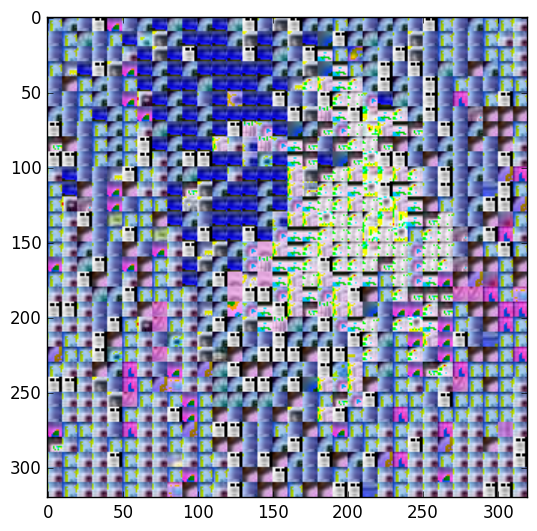

In [94]:
# check how well we did
imshow(mosaic_image);

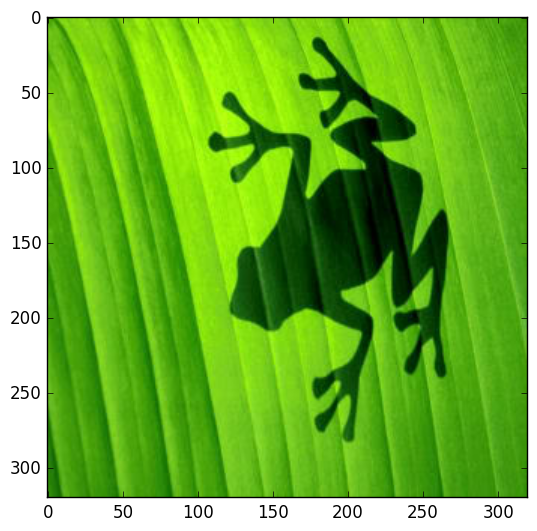

In [93]:
imshow(test_image);